In [ ]:
%cd ..

In [ ]:
import sys
sys.path.insert(0,'..')

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import osmnx as ox
import networkx as nx
from utils.utils import *

In [2]:
G = ox.load_graphml("data/osmnx/graph.graphml")

In [3]:
graph_nodes, graph_edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

# Match GPS data to map

In [4]:
public_gps_df = pd.read_csv("data/public/public_gps_traces_bbox.csv")

In [5]:
nearest_edges, dists = ox.nearest_edges(G, public_gps_df["longitude"], public_gps_df["latitude"], return_dist=True, interpolate=metres_to_dist(INTERPOLATION_DIST_NEAREST_EDGE))

In [6]:
public_gps_df["ne"] = nearest_edges
public_gps_df["dist"] = dists

In [7]:
matched_public_gps_df = threshold_on_col(public_gps_df)

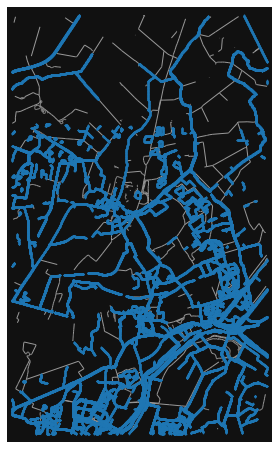

In [8]:
fig, ax = ox.plot_graph(G, node_size=0, show=False, close=False)
ax.scatter(public_gps_df["longitude"], public_gps_df["latitude"], s=2, marker='.')
plt.show()

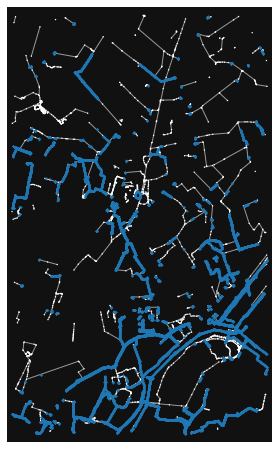

In [9]:
fig, ax = ox.plot_graph(G, node_size=2, show=False, close=False)
ax.scatter(matched_public_gps_df["longitude"], matched_public_gps_df["latitude"], s=2, marker='.')
plt.show()

In [10]:
matched_graph_edges_public = match_nearest_edges(graph_edges, matched_public_gps_df)

In [11]:
matched_graph_edges_public = matched_graph_edges_public.assign(activity=matched_graph_edges_public["tracks"])

In [12]:
matched_graph_edges_public = matched_graph_edges_public \
                                .loc[matched_graph_edges_public["count"] > matched_graph_edges_public["length"] / THRESH_EDGE_MAX_POINT_SEPARATION_PUBLIC_GPS] \
                                .drop(columns=["count", "tracks"])

In [13]:
matched_graph_edges_public = filter_large_subgraphs(graph_nodes, matched_graph_edges_public)

In [14]:
matched_graph_edges_public.to_file("analysis_saves/matched_graph_edges_public.shp")

In [15]:
G_match_public = ox.graph_from_gdfs(graph_nodes, matched_graph_edges_public).to_undirected()

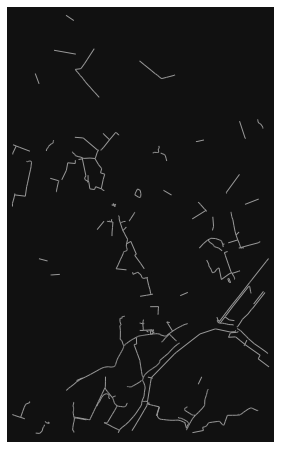

In [16]:
fig, ax = ox.plot_graph(G_match_public, node_size=0)

# Match ROW data to map

In [17]:
row_df = pd.read_csv("data/row/row_bbox.csv")

In [18]:
nearest_edges, dists = ox.nearest_edges(G, row_df["longitude"], row_df["latitude"], return_dist=True, interpolate=metres_to_dist(INTERPOLATION_DIST_NEAREST_EDGE)) 
#TODO: return top 2 nearest edges to account for when there's many closely spaced edges (e.g. around a bend) and the edge lengths become less than the interpolation distance.

In [19]:
row_df["ne"] = nearest_edges
row_df["dist"] = dists

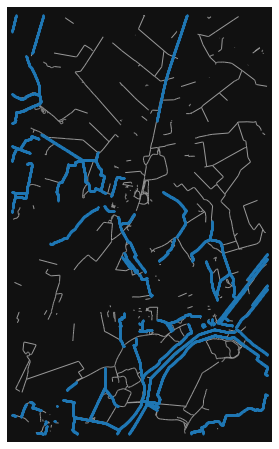

In [20]:
fig, ax = ox.plot_graph(G, node_size=0, show=False, close=False)
ax.scatter(row_df["longitude"], row_df["latitude"], s=4, marker='.')
plt.show()

In [21]:
matched_row_df = threshold_on_col(row_df)

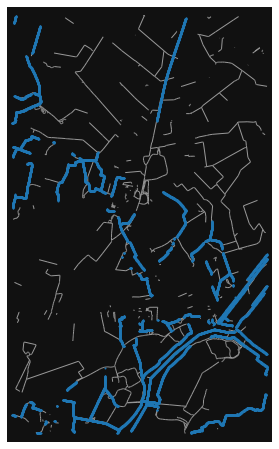

In [22]:
fig, ax = ox.plot_graph(G, node_size=0, show=False, close=False)
ax.scatter(matched_row_df["longitude"], matched_row_df["latitude"], s=4, marker='.')
plt.show()

In [23]:
matched_graph_edges_row = match_nearest_edges(graph_edges, matched_row_df)

In [30]:
matched_graph_edges_row = matched_graph_edges_row \
                            .assign(row=matched_graph_edges_row["count"] > matched_graph_edges_row["length"] / THRESH_EDGE_MAX_POINT_SEPARATION_ROW_GPS) \
                            .drop(columns=["count", "tracks"])

In [31]:
matched_graph_edges_row = matched_graph_edges_row.loc[matched_graph_edges_row["row"]]

In [32]:
matched_graph_edges_row = filter_large_subgraphs(graph_nodes, matched_graph_edges_row)

In [33]:
matched_graph_edges_row.to_file("analysis_saves/matched_graph_edges_row.shp")

In [34]:
G_match_row = ox.graph_from_gdfs(graph_nodes, matched_graph_edges_row).to_undirected()

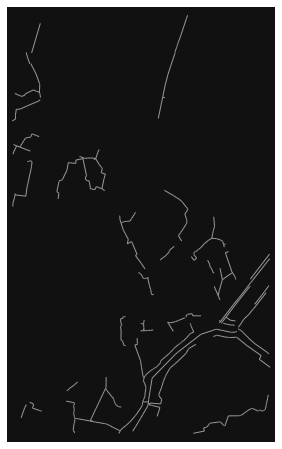

In [35]:
fig, ax = ox.plot_graph(G_match_row, node_size=0)

# Join GPS matched edges and ROW matched edges

In [36]:
matched_graph_edges_public = gpd.read_file("analysis_saves/matched_graph_edges_public.shp").set_index(["u","v","key"])
matched_graph_edges_row    = gpd.read_file("analysis_saves/matched_graph_edges_row.shp"   ).set_index(["u","v","key"])

In [37]:
df1, df2 = merge_on_edges(matched_graph_edges_public, matched_graph_edges_row, hows=["inner", "left_only"], del_cols=["count, tracks"])

df1["row"] = df1["row"] == 1
df2["row"] = df2["row"] == 1

In [38]:
public_row_df = pd.concat([df1, df2], axis=0).astype(graph_edges.dtypes.to_dict())

In [39]:
public_row_df["activity"] = raw_activity_to_percentage(public_row_df["activity"])

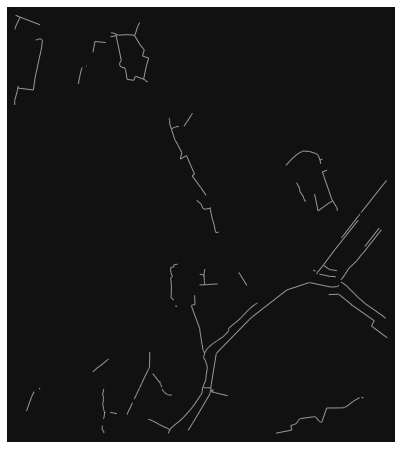

In [40]:
fig, ax = ox.plot_graph(ox.graph_from_gdfs(graph_nodes, public_row_df[public_row_df["row"] == True]), node_size=0)

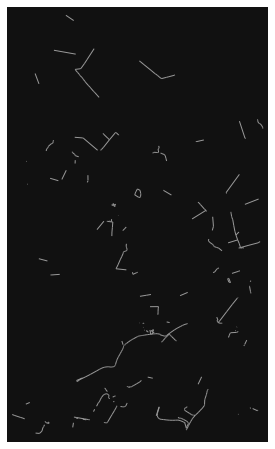

In [41]:
fig, ax = ox.plot_graph(ox.graph_from_gdfs(graph_nodes, public_row_df[public_row_df["row"] == False]), node_size=0)

In [42]:
ox.save_graphml(ox.graph_from_gdfs(graph_nodes, public_row_df[public_row_df["row"] == True]).to_undirected(),  "output/G_busyrow.graphml")
ox.save_graphml(ox.graph_from_gdfs(graph_nodes, public_row_df[public_row_df["row"] == False]).to_undirected(), "output/G_busynonrow.graphml")

In [131]:
def _thresh(x,t): return x[x<t]

(array([468., 126.,  59.,  24.,  11.,   9.,   3.,   4.,   0.,   1.]),
 array([0.03409072, 0.45687707, 0.87966342, 1.30244978, 1.72523613,
        2.14802249, 2.57080884, 2.9935952 , 3.41638155, 3.83916791,
        4.26195426]),
 <BarContainer object of 10 artists>)

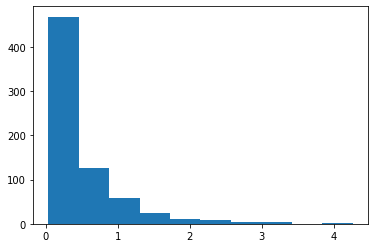

In [133]:
plt.hist(_thresh(df1["activity"].to_numpy(), 5))

(array([1049.,  228.,   82.,   29.,   17.,   10.,    8.,    6.,    2.,
           2.]),
 array([0.03341732, 0.52880333, 1.02418933, 1.51957533, 2.01496133,
        2.51034734, 3.00573334, 3.50111934, 3.99650535, 4.49189135,
        4.98727735]),
 <BarContainer object of 10 artists>)

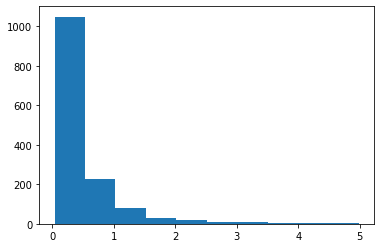

In [134]:
plt.hist(_thresh(df2["activity"].to_numpy(), 5))